In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
def get_titeseq_replicate_df(replicate_number='1'):

    data_df_full = pd.read_csv(f'data/replicate_{replicate_number}.csv',index_col=[0])
    y_cols = list(data_df_full.columns[14:58])
    cols = y_cols.copy()
    # Currently concatenating CDR1-H and CDR3-H sequencnes. Not sure if correct.
    data_df_full['x'] = (data_df_full['CDR1H_AA']+data_df_full['CDR3H_AA']).values
    cols.insert(0,'x')
    data_df = data_df_full[cols].copy()
    
    return data_df
    

In [3]:
replicate_1_df = get_titeseq_replicate_df('1')
replicate_2_df = get_titeseq_replicate_df('2')
replicate_3_df = get_titeseq_replicate_df('3')

data_df = replicate_1_df.append(replicate_2_df, ignore_index=True).append(replicate_3_df, ignore_index=True).reset_index(drop=True).copy()

In [4]:
data_df_full_rep_1 = pd.read_csv(f'data/replicate_1.csv',index_col=[0])
y_cols = list(data_df_full_rep_1.columns[14:58])
X = data_df['x']
y = data_df[y_cols]

In [5]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y',]


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=20, Y=44


In [6]:
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

# # instantiate gpmap object
# gpmap = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
#                                               alphabet=alphabet,
#                                               number_latent_nodes=2)



2022-08-03 20:38:21.288136: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [8]:
# read in parameters

# number of reads in each bin summed
N_y = np.sum(y,axis=0)

In [9]:
print(N_y)

fluorescein0bin0          15885950
fluorescein0bin1            845949
fluorescein0bin2          14646947
fluorescein0bin3            480168
fluorescein10^-5.5bin0     4938811
fluorescein10^-5.5bin1     3558812
fluorescein10^-5.5bin2     7335952
fluorescein10^-5.5bin3     7306329
fluorescein10^-5bin0      12323072
fluorescein10^-5bin1       1386792
fluorescein10^-5bin2      14067051
fluorescein10^-5bin3      14797633
fluorescein10^-6.5bin0     7778006
fluorescein10^-6.5bin1     1084990
fluorescein10^-6.5bin2     6335215
fluorescein10^-6.5bin3    14460000
fluorescein10^-6bin0       1870048
fluorescein10^-6bin1       6027256
fluorescein10^-6bin2       2933272
fluorescein10^-6bin3      10097157
fluorescein10^-7.5bin0     3535644
fluorescein10^-7.5bin1     1078611
fluorescein10^-7.5bin2     3070755
fluorescein10^-7.5bin3     3000078
fluorescein10^-7bin0       3645702
fluorescein10^-7bin1        565856
fluorescein10^-7bin2       8837515
fluorescein10^-7bin3       2756860
fluorescein10^-8.5bi

#### I approximated these values from Fig 2B

In [10]:
bounds = np.array([[0,180],[180,1400],[1400,10500],[10500,250000]])
bounds_df = pd.DataFrame(bounds,columns=['lower_bound','upper_bound'])
f_y_lower_bounds = bounds_df['lower_bound'].values
f_y_upper_bounds = bounds_df['upper_bound'].values
bounds_df

,lower_bound,upper_bound
0,0,180
1,180,1400
2,1400,10500
3,10500,250000


### I don't know how to obtain these values
Using arbitrary values for now just to be able to debug Titeseq MP.
Get these from figure 2B

In [11]:
mu_neg = 50
mu_pos = 700000
sigma_neg = 100
sigma_pos = 50000

In [12]:
mp_list = [mavenn.measurement_process_layers.DiscreteAgnosticMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=4,
                                                                      K=50,
                                                                      eta=1e-5,)
           for mp in range(len(y_cols)//4)
          ]

In [13]:
# there are 16 measurement processes in this 
len(mp_list)

11

In [14]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=mp_list)

In [15]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 444)]       0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 400)          0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           401         ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

In [16]:
# Set training data
model.set_data(x=x_train,
               
               y_list=[
                       y_train[y_cols[0:4]].values,
                       y_train[y_cols[4:8]].values,
                       y_train[y_cols[8:12]].values,
                       y_train[y_cols[12:16]].values,
                       y_train[y_cols[16:20]].values,
                       y_train[y_cols[20:24]].values,
                       y_train[y_cols[24:28]].values,
                       y_train[y_cols[28:32]].values,
                       y_train[y_cols[32:36]].values,
                       y_train[y_cols[36:40]].values,
                       y_train[y_cols[40:44]].values,                                                        
                      ],

               shuffle=False)

N = 10,487 observations set as training data.
Using 19.4% for validation.
Time to set data: 0.465 sec.


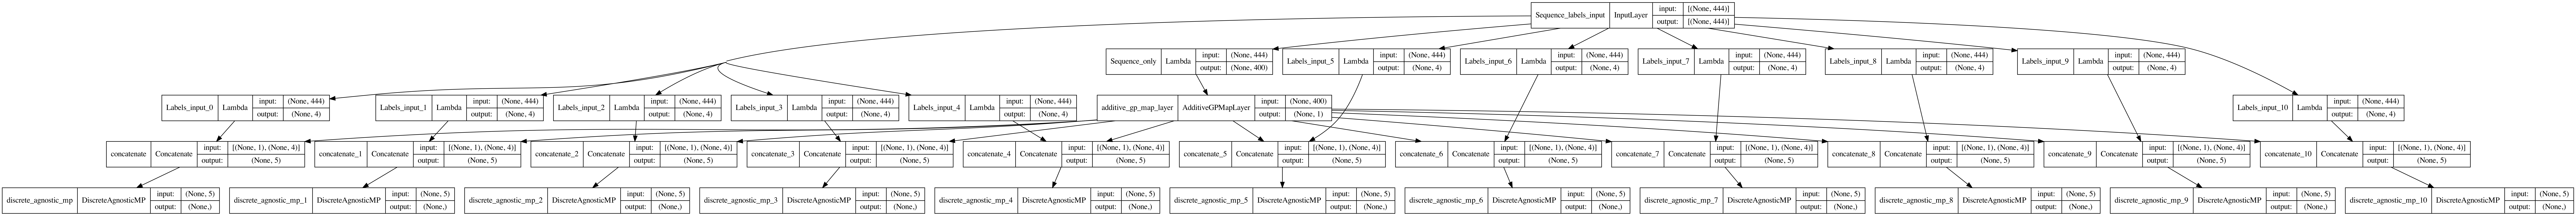

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False,dpi=300,to_file='pngs/DiscreteAgnostic_MP/titeseq16_dar.png')

In [18]:

# Fit model to data
model.fit(learning_rate=.0001,
          epochs=350,
          batch_size=100,
          try_tqdm = False,
          early_stopping=False,
          early_stopping_patience=10,
          linear_initialization=False)

Epoch 1/350
85/85 [==============================] - 13s 32ms/step - loss: 4125738.0000 - discrete_agnostic_mp_loss: 432915.8438 - discrete_agnostic_mp_1_loss: 317582.8750 - discrete_agnostic_mp_2_loss: 583697.2500 - discrete_agnostic_mp_3_loss: 396890.1562 - discrete_agnostic_mp_4_loss: 290392.5000 - discrete_agnostic_mp_5_loss: 140019.8438 - discrete_agnostic_mp_6_loss: 204098.5000 - discrete_agnostic_mp_7_loss: 530628.5625 - discrete_agnostic_mp_8_loss: 315595.3125 - discrete_agnostic_mp_9_loss: 483688.4375 - discrete_agnostic_mp_10_loss: 430228.7188 - I_var: -0.1174 - val_loss: 2478967.5000 - val_discrete_agnostic_mp_loss: 254533.2500 - val_discrete_agnostic_mp_1_loss: 203721.8281 - val_discrete_agnostic_mp_2_loss: 342368.0938 - val_discrete_agnostic_mp_3_loss: 254473.0938 - val_discrete_agnostic_mp_4_loss: 173182.2344 - val_discrete_agnostic_mp_5_loss: 109344.0156 - val_discrete_agnostic_mp_6_loss: 160735.2188 - val_discrete_agnostic_mp_7_loss: 312414.4688 - val_discrete_agnostic_

85/85 [==============================] - 1s 9ms/step - loss: 3634567.7500 - discrete_agnostic_mp_loss: 311923.8125 - discrete_agnostic_mp_1_loss: 300408.1875 - discrete_agnostic_mp_2_loss: 527841.5000 - discrete_agnostic_mp_3_loss: 346076.2188 - discrete_agnostic_mp_4_loss: 247691.6719 - discrete_agnostic_mp_5_loss: 134469.2031 - discrete_agnostic_mp_6_loss: 167300.5469 - discrete_agnostic_mp_7_loss: 469167.8125 - discrete_agnostic_mp_8_loss: 293882.2500 - discrete_agnostic_mp_9_loss: 436044.1250 - discrete_agnostic_mp_10_loss: 399761.5000 - I_var: -0.1459 - val_loss: 2334675.2500 - val_discrete_agnostic_mp_loss: 195595.2812 - val_discrete_agnostic_mp_1_loss: 197400.6250 - val_discrete_agnostic_mp_2_loss: 318602.4688 - val_discrete_agnostic_mp_3_loss: 246386.9375 - val_discrete_agnostic_mp_4_loss: 163443.0781 - val_discrete_agnostic_mp_5_loss: 106750.6016 - val_discrete_agnostic_mp_6_loss: 139288.7031 - val_discrete_agnostic_mp_7_loss: 308416.7188 - val_discrete_agnostic_mp_8_loss: 175

85/85 [==============================] - 1s 9ms/step - loss: 3527818.2500 - discrete_agnostic_mp_loss: 282238.9375 - discrete_agnostic_mp_1_loss: 299169.6875 - discrete_agnostic_mp_2_loss: 512737.7500 - discrete_agnostic_mp_3_loss: 333021.1250 - discrete_agnostic_mp_4_loss: 236856.9219 - discrete_agnostic_mp_5_loss: 133580.0312 - discrete_agnostic_mp_6_loss: 162096.2812 - discrete_agnostic_mp_7_loss: 453746.2188 - discrete_agnostic_mp_8_loss: 290386.8750 - discrete_agnostic_mp_9_loss: 429726.4688 - discrete_agnostic_mp_10_loss: 394257.9062 - I_var: -0.2117 - val_loss: 2328550.5000 - val_discrete_agnostic_mp_loss: 178891.4688 - val_discrete_agnostic_mp_1_loss: 200967.4375 - val_discrete_agnostic_mp_2_loss: 315159.1250 - val_discrete_agnostic_mp_3_loss: 247076.1875 - val_discrete_agnostic_mp_4_loss: 164630.6406 - val_discrete_agnostic_mp_5_loss: 106675.7188 - val_discrete_agnostic_mp_6_loss: 138473.1094 - val_discrete_agnostic_mp_7_loss: 305840.3125 - val_discrete_agnostic_mp_8_loss: 178

85/85 [==============================] - 1s 10ms/step - loss: 3509729.2500 - discrete_agnostic_mp_loss: 276398.5312 - discrete_agnostic_mp_1_loss: 299774.9375 - discrete_agnostic_mp_2_loss: 509175.0312 - discrete_agnostic_mp_3_loss: 330491.1250 - discrete_agnostic_mp_4_loss: 235937.6562 - discrete_agnostic_mp_5_loss: 133514.8125 - discrete_agnostic_mp_6_loss: 160896.7812 - discrete_agnostic_mp_7_loss: 449846.8750 - discrete_agnostic_mp_8_loss: 290725.4375 - discrete_agnostic_mp_9_loss: 429003.9375 - discrete_agnostic_mp_10_loss: 393964.1875 - I_var: -0.2100 - val_loss: 2312945.7500 - val_discrete_agnostic_mp_loss: 174359.0625 - val_discrete_agnostic_mp_1_loss: 201135.9844 - val_discrete_agnostic_mp_2_loss: 311747.2188 - val_discrete_agnostic_mp_3_loss: 244772.9531 - val_discrete_agnostic_mp_4_loss: 164204.2031 - val_discrete_agnostic_mp_5_loss: 106128.2188 - val_discrete_agnostic_mp_6_loss: 137428.9531 - val_discrete_agnostic_mp_7_loss: 301346.3125 - val_discrete_agnostic_mp_8_loss: 17

85/85 [==============================] - 1s 14ms/step - loss: 3496570.0000 - discrete_agnostic_mp_loss: 274632.1562 - discrete_agnostic_mp_1_loss: 299005.4375 - discrete_agnostic_mp_2_loss: 507426.1562 - discrete_agnostic_mp_3_loss: 328335.2500 - discrete_agnostic_mp_4_loss: 235056.4531 - discrete_agnostic_mp_5_loss: 133267.0625 - discrete_agnostic_mp_6_loss: 160267.0000 - discrete_agnostic_mp_7_loss: 448199.4688 - discrete_agnostic_mp_8_loss: 290442.4375 - discrete_agnostic_mp_9_loss: 427512.7812 - discrete_agnostic_mp_10_loss: 392425.7812 - I_var: -0.2093 - val_loss: 2308034.7500 - val_discrete_agnostic_mp_loss: 172610.4062 - val_discrete_agnostic_mp_1_loss: 201905.3906 - val_discrete_agnostic_mp_2_loss: 310653.8750 - val_discrete_agnostic_mp_3_loss: 244639.0000 - val_discrete_agnostic_mp_4_loss: 164494.9219 - val_discrete_agnostic_mp_5_loss: 106144.0547 - val_discrete_agnostic_mp_6_loss: 136692.0781 - val_discrete_agnostic_mp_7_loss: 298860.5625 - val_discrete_agnostic_mp_8_loss: 17

85/85 [==============================] - 1s 13ms/step - loss: 3491843.0000 - discrete_agnostic_mp_loss: 274450.0938 - discrete_agnostic_mp_1_loss: 298572.4062 - discrete_agnostic_mp_2_loss: 506963.8125 - discrete_agnostic_mp_3_loss: 327120.9375 - discrete_agnostic_mp_4_loss: 234802.9062 - discrete_agnostic_mp_5_loss: 133320.2031 - discrete_agnostic_mp_6_loss: 160118.2812 - discrete_agnostic_mp_7_loss: 447634.8750 - discrete_agnostic_mp_8_loss: 290234.6875 - discrete_agnostic_mp_9_loss: 426598.3750 - discrete_agnostic_mp_10_loss: 392026.1250 - I_var: -0.1993 - val_loss: 2304331.7500 - val_discrete_agnostic_mp_loss: 172109.8125 - val_discrete_agnostic_mp_1_loss: 202039.3594 - val_discrete_agnostic_mp_2_loss: 309969.5000 - val_discrete_agnostic_mp_3_loss: 243975.0312 - val_discrete_agnostic_mp_4_loss: 164791.6250 - val_discrete_agnostic_mp_5_loss: 106316.5234 - val_discrete_agnostic_mp_6_loss: 136184.9844 - val_discrete_agnostic_mp_7_loss: 297806.0312 - val_discrete_agnostic_mp_8_loss: 17

85/85 [==============================] - 2s 18ms/step - loss: 3479817.2500 - discrete_agnostic_mp_loss: 274180.4062 - discrete_agnostic_mp_1_loss: 297816.9688 - discrete_agnostic_mp_2_loss: 505900.4062 - discrete_agnostic_mp_3_loss: 325978.4688 - discrete_agnostic_mp_4_loss: 233651.9375 - discrete_agnostic_mp_5_loss: 133087.7656 - discrete_agnostic_mp_6_loss: 159863.0000 - discrete_agnostic_mp_7_loss: 445857.4688 - discrete_agnostic_mp_8_loss: 288895.1250 - discrete_agnostic_mp_9_loss: 424697.5938 - discrete_agnostic_mp_10_loss: 389888.5000 - I_var: -0.1994 - val_loss: 2297787.2500 - val_discrete_agnostic_mp_loss: 172174.1562 - val_discrete_agnostic_mp_1_loss: 201457.3750 - val_discrete_agnostic_mp_2_loss: 309517.3750 - val_discrete_agnostic_mp_3_loss: 242903.3906 - val_discrete_agnostic_mp_4_loss: 164354.9844 - val_discrete_agnostic_mp_5_loss: 106345.8750 - val_discrete_agnostic_mp_6_loss: 135666.6719 - val_discrete_agnostic_mp_7_loss: 296614.1875 - val_discrete_agnostic_mp_8_loss: 17

85/85 [==============================] - 1s 13ms/step - loss: 3470554.2500 - discrete_agnostic_mp_loss: 274805.0000 - discrete_agnostic_mp_1_loss: 296835.3438 - discrete_agnostic_mp_2_loss: 505455.7812 - discrete_agnostic_mp_3_loss: 324704.0625 - discrete_agnostic_mp_4_loss: 232317.7500 - discrete_agnostic_mp_5_loss: 133006.3750 - discrete_agnostic_mp_6_loss: 159826.7344 - discrete_agnostic_mp_7_loss: 444995.3750 - discrete_agnostic_mp_8_loss: 287516.5625 - discrete_agnostic_mp_9_loss: 422864.8750 - discrete_agnostic_mp_10_loss: 388226.4688 - I_var: -0.2008 - val_loss: 2295317.5000 - val_discrete_agnostic_mp_loss: 172765.5156 - val_discrete_agnostic_mp_1_loss: 200773.0938 - val_discrete_agnostic_mp_2_loss: 309874.3438 - val_discrete_agnostic_mp_3_loss: 241959.4531 - val_discrete_agnostic_mp_4_loss: 164112.2500 - val_discrete_agnostic_mp_5_loss: 106488.8516 - val_discrete_agnostic_mp_6_loss: 135615.5781 - val_discrete_agnostic_mp_7_loss: 296556.7812 - val_discrete_agnostic_mp_8_loss: 17

85/85 [==============================] - 1s 11ms/step - loss: 3455647.7500 - discrete_agnostic_mp_loss: 275852.0000 - discrete_agnostic_mp_1_loss: 295128.4375 - discrete_agnostic_mp_2_loss: 504481.5938 - discrete_agnostic_mp_3_loss: 322183.6250 - discrete_agnostic_mp_4_loss: 230522.0938 - discrete_agnostic_mp_5_loss: 132664.8281 - discrete_agnostic_mp_6_loss: 159665.3594 - discrete_agnostic_mp_7_loss: 443531.5312 - discrete_agnostic_mp_8_loss: 285641.3438 - discrete_agnostic_mp_9_loss: 420687.7188 - discrete_agnostic_mp_10_loss: 385289.9375 - I_var: -0.1815 - val_loss: 2285299.5000 - val_discrete_agnostic_mp_loss: 173413.8125 - val_discrete_agnostic_mp_1_loss: 199520.3438 - val_discrete_agnostic_mp_2_loss: 309591.3750 - val_discrete_agnostic_mp_3_loss: 240429.6562 - val_discrete_agnostic_mp_4_loss: 163124.4844 - val_discrete_agnostic_mp_5_loss: 106396.2188 - val_discrete_agnostic_mp_6_loss: 135000.4062 - val_discrete_agnostic_mp_7_loss: 294874.9375 - val_discrete_agnostic_mp_8_loss: 17

85/85 [==============================] - 1s 9ms/step - loss: 3442907.7500 - discrete_agnostic_mp_loss: 277062.7500 - discrete_agnostic_mp_1_loss: 293670.1250 - discrete_agnostic_mp_2_loss: 504253.0938 - discrete_agnostic_mp_3_loss: 320085.4688 - discrete_agnostic_mp_4_loss: 229119.9688 - discrete_agnostic_mp_5_loss: 132499.4219 - discrete_agnostic_mp_6_loss: 159615.6875 - discrete_agnostic_mp_7_loss: 442669.5312 - discrete_agnostic_mp_8_loss: 283759.4062 - discrete_agnostic_mp_9_loss: 417724.7500 - discrete_agnostic_mp_10_loss: 382447.5000 - I_var: -0.1660 - val_loss: 2272023.7500 - val_discrete_agnostic_mp_loss: 174160.8125 - val_discrete_agnostic_mp_1_loss: 197841.4375 - val_discrete_agnostic_mp_2_loss: 309154.3438 - val_discrete_agnostic_mp_3_loss: 238534.7656 - val_discrete_agnostic_mp_4_loss: 161754.7812 - val_discrete_agnostic_mp_5_loss: 106133.1016 - val_discrete_agnostic_mp_6_loss: 134340.7656 - val_discrete_agnostic_mp_7_loss: 292882.0000 - val_discrete_agnostic_mp_8_loss: 175

85/85 [==============================] - 1s 10ms/step - loss: 3420201.7500 - discrete_agnostic_mp_loss: 277201.8438 - discrete_agnostic_mp_1_loss: 291742.0625 - discrete_agnostic_mp_2_loss: 502533.4688 - discrete_agnostic_mp_3_loss: 317560.1250 - discrete_agnostic_mp_4_loss: 226876.1094 - discrete_agnostic_mp_5_loss: 131903.7656 - discrete_agnostic_mp_6_loss: 159179.9844 - discrete_agnostic_mp_7_loss: 439900.4688 - discrete_agnostic_mp_8_loss: 280724.1562 - discrete_agnostic_mp_9_loss: 414090.2500 - discrete_agnostic_mp_10_loss: 378489.8438 - I_var: -0.1508 - val_loss: 2267614.0000 - val_discrete_agnostic_mp_loss: 174611.0156 - val_discrete_agnostic_mp_1_loss: 196979.4688 - val_discrete_agnostic_mp_2_loss: 309791.7188 - val_discrete_agnostic_mp_3_loss: 237298.7812 - val_discrete_agnostic_mp_4_loss: 161661.7188 - val_discrete_agnostic_mp_5_loss: 106298.4297 - val_discrete_agnostic_mp_6_loss: 134122.6719 - val_discrete_agnostic_mp_7_loss: 292798.2500 - val_discrete_agnostic_mp_8_loss: 17

85/85 [==============================] - 1s 10ms/step - loss: 3397285.0000 - discrete_agnostic_mp_loss: 278313.4688 - discrete_agnostic_mp_1_loss: 289274.7500 - discrete_agnostic_mp_2_loss: 501135.6562 - discrete_agnostic_mp_3_loss: 314422.8750 - discrete_agnostic_mp_4_loss: 224278.3281 - discrete_agnostic_mp_5_loss: 131276.6875 - discrete_agnostic_mp_6_loss: 159158.2344 - discrete_agnostic_mp_7_loss: 438035.3750 - discrete_agnostic_mp_8_loss: 277678.6562 - discrete_agnostic_mp_9_loss: 410158.0312 - discrete_agnostic_mp_10_loss: 373552.8438 - I_var: -0.1203 - val_loss: 2252707.0000 - val_discrete_agnostic_mp_loss: 175049.0781 - val_discrete_agnostic_mp_1_loss: 195016.4375 - val_discrete_agnostic_mp_2_loss: 309509.1875 - val_discrete_agnostic_mp_3_loss: 235026.3438 - val_discrete_agnostic_mp_4_loss: 160435.2344 - val_discrete_agnostic_mp_5_loss: 105950.3516 - val_discrete_agnostic_mp_6_loss: 133425.8594 - val_discrete_agnostic_mp_7_loss: 291057.9688 - val_discrete_agnostic_mp_8_loss: 17

85/85 [==============================] - 1s 11ms/step - loss: 3372424.2500 - discrete_agnostic_mp_loss: 278581.2500 - discrete_agnostic_mp_1_loss: 286999.4375 - discrete_agnostic_mp_2_loss: 500165.3750 - discrete_agnostic_mp_3_loss: 311352.1250 - discrete_agnostic_mp_4_loss: 222022.6094 - discrete_agnostic_mp_5_loss: 130347.6875 - discrete_agnostic_mp_6_loss: 158716.8438 - discrete_agnostic_mp_7_loss: 435317.7500 - discrete_agnostic_mp_8_loss: 274613.2188 - discrete_agnostic_mp_9_loss: 405723.9688 - discrete_agnostic_mp_10_loss: 368583.5000 - I_var: -0.0977 - val_loss: 2238173.7500 - val_discrete_agnostic_mp_loss: 175098.5156 - val_discrete_agnostic_mp_1_loss: 193508.5469 - val_discrete_agnostic_mp_2_loss: 309063.9375 - val_discrete_agnostic_mp_3_loss: 232688.6875 - val_discrete_agnostic_mp_4_loss: 159573.8438 - val_discrete_agnostic_mp_5_loss: 105644.8047 - val_discrete_agnostic_mp_6_loss: 132660.9688 - val_discrete_agnostic_mp_7_loss: 289295.9688 - val_discrete_agnostic_mp_8_loss: 17

85/85 [==============================] - 1s 10ms/step - loss: 3344537.7500 - discrete_agnostic_mp_loss: 278279.5000 - discrete_agnostic_mp_1_loss: 284539.3438 - discrete_agnostic_mp_2_loss: 497621.2500 - discrete_agnostic_mp_3_loss: 307839.5312 - discrete_agnostic_mp_4_loss: 219620.3125 - discrete_agnostic_mp_5_loss: 129301.6484 - discrete_agnostic_mp_6_loss: 158282.2656 - discrete_agnostic_mp_7_loss: 432424.5000 - discrete_agnostic_mp_8_loss: 271597.4375 - discrete_agnostic_mp_9_loss: 401366.4375 - discrete_agnostic_mp_10_loss: 363665.5312 - I_var: -0.0618 - val_loss: 2220337.2500 - val_discrete_agnostic_mp_loss: 174545.1406 - val_discrete_agnostic_mp_1_loss: 191866.1406 - val_discrete_agnostic_mp_2_loss: 308100.4375 - val_discrete_agnostic_mp_3_loss: 229670.3750 - val_discrete_agnostic_mp_4_loss: 158516.2656 - val_discrete_agnostic_mp_5_loss: 105075.2969 - val_discrete_agnostic_mp_6_loss: 131488.4062 - val_discrete_agnostic_mp_7_loss: 286549.9688 - val_discrete_agnostic_mp_8_loss: 16

85/85 [==============================] - 1s 10ms/step - loss: 3316063.0000 - discrete_agnostic_mp_loss: 278118.6875 - discrete_agnostic_mp_1_loss: 282242.1562 - discrete_agnostic_mp_2_loss: 495891.3125 - discrete_agnostic_mp_3_loss: 304354.1562 - discrete_agnostic_mp_4_loss: 217280.5312 - discrete_agnostic_mp_5_loss: 127970.7969 - discrete_agnostic_mp_6_loss: 157776.7969 - discrete_agnostic_mp_7_loss: 429174.7188 - discrete_agnostic_mp_8_loss: 268477.8125 - discrete_agnostic_mp_9_loss: 396498.4375 - discrete_agnostic_mp_10_loss: 358277.9688 - I_var: -0.0237 - val_loss: 2197088.7500 - val_discrete_agnostic_mp_loss: 173899.0000 - val_discrete_agnostic_mp_1_loss: 190085.7500 - val_discrete_agnostic_mp_2_loss: 306418.8438 - val_discrete_agnostic_mp_3_loss: 225863.8750 - val_discrete_agnostic_mp_4_loss: 156963.4062 - val_discrete_agnostic_mp_5_loss: 104206.7422 - val_discrete_agnostic_mp_6_loss: 129839.0312 - val_discrete_agnostic_mp_7_loss: 282790.4375 - val_discrete_agnostic_mp_8_loss: 16

85/85 [==============================] - 2s 20ms/step - loss: 3282098.0000 - discrete_agnostic_mp_loss: 277441.0000 - discrete_agnostic_mp_1_loss: 279886.6875 - discrete_agnostic_mp_2_loss: 492586.5938 - discrete_agnostic_mp_3_loss: 300345.9688 - discrete_agnostic_mp_4_loss: 214292.6562 - discrete_agnostic_mp_5_loss: 126373.2109 - discrete_agnostic_mp_6_loss: 157005.4375 - discrete_agnostic_mp_7_loss: 424520.7812 - discrete_agnostic_mp_8_loss: 264869.4375 - discrete_agnostic_mp_9_loss: 391869.9688 - discrete_agnostic_mp_10_loss: 352905.6250 - I_var: 0.0025 - val_loss: 2169990.7500 - val_discrete_agnostic_mp_loss: 173405.5156 - val_discrete_agnostic_mp_1_loss: 188328.9688 - val_discrete_agnostic_mp_2_loss: 304325.4375 - val_discrete_agnostic_mp_3_loss: 220852.7969 - val_discrete_agnostic_mp_4_loss: 154988.4219 - val_discrete_agnostic_mp_5_loss: 103173.0469 - val_discrete_agnostic_mp_6_loss: 127956.9141 - val_discrete_agnostic_mp_7_loss: 277704.0938 - val_discrete_agnostic_mp_8_loss: 165

85/85 [==============================] - 1s 13ms/step - loss: 3251704.7500 - discrete_agnostic_mp_loss: 276774.8125 - discrete_agnostic_mp_1_loss: 277999.9062 - discrete_agnostic_mp_2_loss: 489200.7500 - discrete_agnostic_mp_3_loss: 296130.5625 - discrete_agnostic_mp_4_loss: 211610.0469 - discrete_agnostic_mp_5_loss: 124772.6016 - discrete_agnostic_mp_6_loss: 156168.3125 - discrete_agnostic_mp_7_loss: 420144.2188 - discrete_agnostic_mp_8_loss: 262077.0469 - discrete_agnostic_mp_9_loss: 388129.0625 - discrete_agnostic_mp_10_loss: 348696.8438 - I_var: 0.0270 - val_loss: 2142359.5000 - val_discrete_agnostic_mp_loss: 172581.2031 - val_discrete_agnostic_mp_1_loss: 187134.4062 - val_discrete_agnostic_mp_2_loss: 301334.0000 - val_discrete_agnostic_mp_3_loss: 215488.8281 - val_discrete_agnostic_mp_4_loss: 152825.1719 - val_discrete_agnostic_mp_5_loss: 102272.7734 - val_discrete_agnostic_mp_6_loss: 125843.7812 - val_discrete_agnostic_mp_7_loss: 271966.6875 - val_discrete_agnostic_mp_8_loss: 163

85/85 [==============================] - 2s 18ms/step - loss: 3217641.7500 - discrete_agnostic_mp_loss: 275841.2188 - discrete_agnostic_mp_1_loss: 276257.4688 - discrete_agnostic_mp_2_loss: 484701.8438 - discrete_agnostic_mp_3_loss: 291516.2188 - discrete_agnostic_mp_4_loss: 208539.4688 - discrete_agnostic_mp_5_loss: 123102.9766 - discrete_agnostic_mp_6_loss: 155220.2500 - discrete_agnostic_mp_7_loss: 414152.6875 - discrete_agnostic_mp_8_loss: 259308.0938 - discrete_agnostic_mp_9_loss: 384271.7500 - discrete_agnostic_mp_10_loss: 344729.2500 - I_var: 0.0620 - val_loss: 2111493.0000 - val_discrete_agnostic_mp_loss: 171782.5781 - val_discrete_agnostic_mp_1_loss: 185857.1094 - val_discrete_agnostic_mp_2_loss: 297560.9375 - val_discrete_agnostic_mp_3_loss: 209351.6562 - val_discrete_agnostic_mp_4_loss: 150219.5938 - val_discrete_agnostic_mp_5_loss: 101480.8047 - val_discrete_agnostic_mp_6_loss: 123358.5156 - val_discrete_agnostic_mp_7_loss: 264638.0938 - val_discrete_agnostic_mp_8_loss: 162

85/85 [==============================] - 2s 22ms/step - loss: 3025142.0000 - discrete_agnostic_mp_loss: 263348.4375 - discrete_agnostic_mp_1_loss: 267276.6250 - discrete_agnostic_mp_2_loss: 460387.5625 - discrete_agnostic_mp_3_loss: 279864.0938 - discrete_agnostic_mp_4_loss: 199537.7500 - discrete_agnostic_mp_5_loss: 117587.9688 - discrete_agnostic_mp_6_loss: 145153.6875 - discrete_agnostic_mp_7_loss: 395681.9688 - discrete_agnostic_mp_8_loss: 241726.8438 - discrete_agnostic_mp_9_loss: 348390.5312 - discrete_agnostic_mp_10_loss: 306187.1250 - I_var: 0.0856 - val_loss: 2078645.1250 - val_discrete_agnostic_mp_loss: 171371.9219 - val_discrete_agnostic_mp_1_loss: 184806.3281 - val_discrete_agnostic_mp_2_loss: 293056.5625 - val_discrete_agnostic_mp_3_loss: 202902.8750 - val_discrete_agnostic_mp_4_loss: 147075.6875 - val_discrete_agnostic_mp_5_loss: 100952.2734 - val_discrete_agnostic_mp_6_loss: 120944.1016 - val_discrete_agnostic_mp_7_loss: 255794.3906 - val_discrete_agnostic_mp_8_loss: 161

85/85 [==============================] - 2s 24ms/step - loss: 3155831.7500 - discrete_agnostic_mp_loss: 274181.2500 - discrete_agnostic_mp_1_loss: 273411.4062 - discrete_agnostic_mp_2_loss: 475386.3125 - discrete_agnostic_mp_3_loss: 283020.2500 - discrete_agnostic_mp_4_loss: 202093.0625 - discrete_agnostic_mp_5_loss: 121082.0156 - discrete_agnostic_mp_6_loss: 153263.2344 - discrete_agnostic_mp_7_loss: 401905.1250 - discrete_agnostic_mp_8_loss: 254277.1719 - discrete_agnostic_mp_9_loss: 378291.7812 - discrete_agnostic_mp_10_loss: 338919.7812 - I_var: 0.1052 - val_loss: 2050736.8750 - val_discrete_agnostic_mp_loss: 170649.9688 - val_discrete_agnostic_mp_1_loss: 183849.9219 - val_discrete_agnostic_mp_2_loss: 289052.6875 - val_discrete_agnostic_mp_3_loss: 197053.7188 - val_discrete_agnostic_mp_4_loss: 144579.9219 - val_discrete_agnostic_mp_5_loss: 100953.5625 - val_discrete_agnostic_mp_6_loss: 118505.5469 - val_discrete_agnostic_mp_7_loss: 247604.1250 - val_discrete_agnostic_mp_8_loss: 160

85/85 [==============================] - 2s 21ms/step - loss: 3132922.2500 - discrete_agnostic_mp_loss: 273930.7188 - discrete_agnostic_mp_1_loss: 272590.1250 - discrete_agnostic_mp_2_loss: 471652.6875 - discrete_agnostic_mp_3_loss: 279802.0625 - discrete_agnostic_mp_4_loss: 199671.6562 - discrete_agnostic_mp_5_loss: 120553.4375 - discrete_agnostic_mp_6_loss: 152439.3594 - discrete_agnostic_mp_7_loss: 396397.4375 - discrete_agnostic_mp_8_loss: 252724.4219 - discrete_agnostic_mp_9_loss: 376105.5000 - discrete_agnostic_mp_10_loss: 337054.9375 - I_var: 0.1160 - val_loss: 2023902.3750 - val_discrete_agnostic_mp_loss: 170289.4062 - val_discrete_agnostic_mp_1_loss: 182776.3281 - val_discrete_agnostic_mp_2_loss: 284922.1250 - val_discrete_agnostic_mp_3_loss: 191962.2344 - val_discrete_agnostic_mp_4_loss: 142169.0938 - val_discrete_agnostic_mp_5_loss: 100879.1641 - val_discrete_agnostic_mp_6_loss: 116332.9219 - val_discrete_agnostic_mp_7_loss: 238994.5469 - val_discrete_agnostic_mp_8_loss: 159

85/85 [==============================] - 2s 19ms/step - loss: 3112317.5000 - discrete_agnostic_mp_loss: 273604.8438 - discrete_agnostic_mp_1_loss: 271315.8438 - discrete_agnostic_mp_2_loss: 468147.7500 - discrete_agnostic_mp_3_loss: 276956.0000 - discrete_agnostic_mp_4_loss: 197828.9375 - discrete_agnostic_mp_5_loss: 120195.7344 - discrete_agnostic_mp_6_loss: 151513.1406 - discrete_agnostic_mp_7_loss: 391362.9375 - discrete_agnostic_mp_8_loss: 251335.3750 - discrete_agnostic_mp_9_loss: 374407.4375 - discrete_agnostic_mp_10_loss: 335649.5000 - I_var: 0.1273 - val_loss: 2003830.2500 - val_discrete_agnostic_mp_loss: 170043.8281 - val_discrete_agnostic_mp_1_loss: 182164.7656 - val_discrete_agnostic_mp_2_loss: 281420.2500 - val_discrete_agnostic_mp_3_loss: 188432.7031 - val_discrete_agnostic_mp_4_loss: 140484.1250 - val_discrete_agnostic_mp_5_loss: 101029.3984 - val_discrete_agnostic_mp_6_loss: 114882.2109 - val_discrete_agnostic_mp_7_loss: 231866.5000 - val_discrete_agnostic_mp_8_loss: 159

85/85 [==============================] - 1s 16ms/step - loss: 3094642.7500 - discrete_agnostic_mp_loss: 273145.5625 - discrete_agnostic_mp_1_loss: 270390.3125 - discrete_agnostic_mp_2_loss: 464828.1250 - discrete_agnostic_mp_3_loss: 275064.4688 - discrete_agnostic_mp_4_loss: 195993.3594 - discrete_agnostic_mp_5_loss: 119862.5625 - discrete_agnostic_mp_6_loss: 150812.2500 - discrete_agnostic_mp_7_loss: 387329.9375 - discrete_agnostic_mp_8_loss: 249934.9375 - discrete_agnostic_mp_9_loss: 373286.0312 - discrete_agnostic_mp_10_loss: 333995.1562 - I_var: 0.1364 - val_loss: 1985086.3750 - val_discrete_agnostic_mp_loss: 169943.3594 - val_discrete_agnostic_mp_1_loss: 181333.1719 - val_discrete_agnostic_mp_2_loss: 278454.8438 - val_discrete_agnostic_mp_3_loss: 185229.6875 - val_discrete_agnostic_mp_4_loss: 139046.7656 - val_discrete_agnostic_mp_5_loss: 101019.8750 - val_discrete_agnostic_mp_6_loss: 113372.2812 - val_discrete_agnostic_mp_7_loss: 225615.9844 - val_discrete_agnostic_mp_8_loss: 158

85/85 [==============================] - 2s 20ms/step - loss: 3081532.7500 - discrete_agnostic_mp_loss: 272970.0312 - discrete_agnostic_mp_1_loss: 269435.8750 - discrete_agnostic_mp_2_loss: 462447.1250 - discrete_agnostic_mp_3_loss: 273635.1875 - discrete_agnostic_mp_4_loss: 194835.0781 - discrete_agnostic_mp_5_loss: 119580.6016 - discrete_agnostic_mp_6_loss: 150154.2188 - discrete_agnostic_mp_7_loss: 384317.2188 - discrete_agnostic_mp_8_loss: 248858.3125 - discrete_agnostic_mp_9_loss: 372371.2812 - discrete_agnostic_mp_10_loss: 332927.7500 - I_var: 0.1451 - val_loss: 1972024.6250 - val_discrete_agnostic_mp_loss: 169868.1562 - val_discrete_agnostic_mp_1_loss: 180674.8750 - val_discrete_agnostic_mp_2_loss: 276183.8125 - val_discrete_agnostic_mp_3_loss: 183237.9375 - val_discrete_agnostic_mp_4_loss: 138143.5469 - val_discrete_agnostic_mp_5_loss: 100951.6562 - val_discrete_agnostic_mp_6_loss: 112302.6875 - val_discrete_agnostic_mp_7_loss: 221386.6719 - val_discrete_agnostic_mp_8_loss: 158

85/85 [==============================] - 2s 18ms/step - loss: 3073380.7500 - discrete_agnostic_mp_loss: 272826.7500 - discrete_agnostic_mp_1_loss: 269040.7188 - discrete_agnostic_mp_2_loss: 461331.8438 - discrete_agnostic_mp_3_loss: 272529.3125 - discrete_agnostic_mp_4_loss: 194210.7031 - discrete_agnostic_mp_5_loss: 119339.7188 - discrete_agnostic_mp_6_loss: 149706.9531 - discrete_agnostic_mp_7_loss: 382129.8438 - discrete_agnostic_mp_8_loss: 248546.8906 - discrete_agnostic_mp_9_loss: 371678.5312 - discrete_agnostic_mp_10_loss: 332039.5938 - I_var: 0.1507 - val_loss: 1961706.6250 - val_discrete_agnostic_mp_loss: 169851.9062 - val_discrete_agnostic_mp_1_loss: 180398.4062 - val_discrete_agnostic_mp_2_loss: 274259.5312 - val_discrete_agnostic_mp_3_loss: 181610.6406 - val_discrete_agnostic_mp_4_loss: 137336.1562 - val_discrete_agnostic_mp_5_loss: 100991.7969 - val_discrete_agnostic_mp_6_loss: 111292.9297 - val_discrete_agnostic_mp_7_loss: 218212.4375 - val_discrete_agnostic_mp_8_loss: 157

85/85 [==============================] - 1s 14ms/step - loss: 3063797.2500 - discrete_agnostic_mp_loss: 272740.9062 - discrete_agnostic_mp_1_loss: 268177.8750 - discrete_agnostic_mp_2_loss: 459637.5000 - discrete_agnostic_mp_3_loss: 271752.4375 - discrete_agnostic_mp_4_loss: 193499.4219 - discrete_agnostic_mp_5_loss: 119029.7656 - discrete_agnostic_mp_6_loss: 149190.6719 - discrete_agnostic_mp_7_loss: 380134.4688 - discrete_agnostic_mp_8_loss: 247781.8438 - discrete_agnostic_mp_9_loss: 370927.5000 - discrete_agnostic_mp_10_loss: 330925.2500 - I_var: 0.1624 - val_loss: 1953123.3750 - val_discrete_agnostic_mp_loss: 169940.3906 - val_discrete_agnostic_mp_1_loss: 179608.4062 - val_discrete_agnostic_mp_2_loss: 272768.0312 - val_discrete_agnostic_mp_3_loss: 180612.4375 - val_discrete_agnostic_mp_4_loss: 136782.7500 - val_discrete_agnostic_mp_5_loss: 100642.9922 - val_discrete_agnostic_mp_6_loss: 110821.4922 - val_discrete_agnostic_mp_7_loss: 215802.1719 - val_discrete_agnostic_mp_8_loss: 157

85/85 [==============================] - 1s 16ms/step - loss: 3060247.7500 - discrete_agnostic_mp_loss: 273011.8125 - discrete_agnostic_mp_1_loss: 267883.2812 - discrete_agnostic_mp_2_loss: 458836.0625 - discrete_agnostic_mp_3_loss: 271416.5000 - discrete_agnostic_mp_4_loss: 193027.7188 - discrete_agnostic_mp_5_loss: 118929.9922 - discrete_agnostic_mp_6_loss: 148997.3438 - discrete_agnostic_mp_7_loss: 379494.6250 - discrete_agnostic_mp_8_loss: 247427.1094 - discrete_agnostic_mp_9_loss: 370760.9062 - discrete_agnostic_mp_10_loss: 330462.4688 - I_var: 0.1637 - val_loss: 1947397.0000 - val_discrete_agnostic_mp_loss: 169950.5625 - val_discrete_agnostic_mp_1_loss: 179249.5938 - val_discrete_agnostic_mp_2_loss: 271681.9062 - val_discrete_agnostic_mp_3_loss: 179808.6719 - val_discrete_agnostic_mp_4_loss: 136385.4688 - val_discrete_agnostic_mp_5_loss: 100561.0703 - val_discrete_agnostic_mp_6_loss: 110364.8984 - val_discrete_agnostic_mp_7_loss: 214426.2656 - val_discrete_agnostic_mp_8_loss: 157

85/85 [==============================] - 1s 13ms/step - loss: 3054129.5000 - discrete_agnostic_mp_loss: 272521.9062 - discrete_agnostic_mp_1_loss: 267412.0938 - discrete_agnostic_mp_2_loss: 457939.3438 - discrete_agnostic_mp_3_loss: 270812.7812 - discrete_agnostic_mp_4_loss: 192602.2344 - discrete_agnostic_mp_5_loss: 118735.6250 - discrete_agnostic_mp_6_loss: 148641.8594 - discrete_agnostic_mp_7_loss: 378433.2812 - discrete_agnostic_mp_8_loss: 246863.7344 - discrete_agnostic_mp_9_loss: 370335.9062 - discrete_agnostic_mp_10_loss: 329830.1875 - I_var: 0.1662 - val_loss: 1942355.3750 - val_discrete_agnostic_mp_loss: 169985.0156 - val_discrete_agnostic_mp_1_loss: 178949.6875 - val_discrete_agnostic_mp_2_loss: 270815.0625 - val_discrete_agnostic_mp_3_loss: 179131.1094 - val_discrete_agnostic_mp_4_loss: 136018.7500 - val_discrete_agnostic_mp_5_loss: 100414.5000 - val_discrete_agnostic_mp_6_loss: 109882.8516 - val_discrete_agnostic_mp_7_loss: 213446.6406 - val_discrete_agnostic_mp_8_loss: 156

85/85 [==============================] - 1s 14ms/step - loss: 3050121.2500 - discrete_agnostic_mp_loss: 272452.5312 - discrete_agnostic_mp_1_loss: 267234.3438 - discrete_agnostic_mp_2_loss: 457099.7812 - discrete_agnostic_mp_3_loss: 270361.4688 - discrete_agnostic_mp_4_loss: 192212.4219 - discrete_agnostic_mp_5_loss: 118642.6250 - discrete_agnostic_mp_6_loss: 148365.9531 - discrete_agnostic_mp_7_loss: 377936.7500 - discrete_agnostic_mp_8_loss: 246501.6094 - discrete_agnostic_mp_9_loss: 369833.9375 - discrete_agnostic_mp_10_loss: 329480.8438 - I_var: 0.1659 - val_loss: 1937459.2500 - val_discrete_agnostic_mp_loss: 170065.5938 - val_discrete_agnostic_mp_1_loss: 178520.3125 - val_discrete_agnostic_mp_2_loss: 270047.2812 - val_discrete_agnostic_mp_3_loss: 178525.7812 - val_discrete_agnostic_mp_4_loss: 135663.5312 - val_discrete_agnostic_mp_5_loss: 100177.2031 - val_discrete_agnostic_mp_6_loss: 109489.1875 - val_discrete_agnostic_mp_7_loss: 212466.7812 - val_discrete_agnostic_mp_8_loss: 156

85/85 [==============================] - 1s 14ms/step - loss: 3047052.5000 - discrete_agnostic_mp_loss: 272421.6250 - discrete_agnostic_mp_1_loss: 266922.8125 - discrete_agnostic_mp_2_loss: 456840.4688 - discrete_agnostic_mp_3_loss: 270138.8125 - discrete_agnostic_mp_4_loss: 191971.5469 - discrete_agnostic_mp_5_loss: 118534.7188 - discrete_agnostic_mp_6_loss: 148168.4062 - discrete_agnostic_mp_7_loss: 377520.4062 - discrete_agnostic_mp_8_loss: 246153.1406 - discrete_agnostic_mp_9_loss: 369384.2812 - discrete_agnostic_mp_10_loss: 328996.2500 - I_var: 0.1709 - val_loss: 1934021.3750 - val_discrete_agnostic_mp_loss: 170073.7188 - val_discrete_agnostic_mp_1_loss: 178326.5469 - val_discrete_agnostic_mp_2_loss: 269176.4062 - val_discrete_agnostic_mp_3_loss: 178246.2188 - val_discrete_agnostic_mp_4_loss: 135412.3281 - val_discrete_agnostic_mp_5_loss: 100093.7422 - val_discrete_agnostic_mp_6_loss: 109335.6406 - val_discrete_agnostic_mp_7_loss: 211690.0312 - val_discrete_agnostic_mp_8_loss: 156

85/85 [==============================] - 1s 10ms/step - loss: 3044178.0000 - discrete_agnostic_mp_loss: 272406.9688 - discrete_agnostic_mp_1_loss: 266793.3438 - discrete_agnostic_mp_2_loss: 456128.0938 - discrete_agnostic_mp_3_loss: 269649.5000 - discrete_agnostic_mp_4_loss: 191591.4062 - discrete_agnostic_mp_5_loss: 118545.5938 - discrete_agnostic_mp_6_loss: 148011.9375 - discrete_agnostic_mp_7_loss: 377250.5938 - discrete_agnostic_mp_8_loss: 245896.5000 - discrete_agnostic_mp_9_loss: 369035.5625 - discrete_agnostic_mp_10_loss: 328867.7812 - I_var: 0.1752 - val_loss: 1932039.8750 - val_discrete_agnostic_mp_loss: 170115.2812 - val_discrete_agnostic_mp_1_loss: 178192.2969 - val_discrete_agnostic_mp_2_loss: 269084.2188 - val_discrete_agnostic_mp_3_loss: 177837.3594 - val_discrete_agnostic_mp_4_loss: 135210.9688 - val_discrete_agnostic_mp_5_loss: 100015.6250 - val_discrete_agnostic_mp_6_loss: 109113.8828 - val_discrete_agnostic_mp_7_loss: 211550.9688 - val_discrete_agnostic_mp_8_loss: 156

85/85 [==============================] - 1s 9ms/step - loss: 3042799.5000 - discrete_agnostic_mp_loss: 272614.4062 - discrete_agnostic_mp_1_loss: 266408.2812 - discrete_agnostic_mp_2_loss: 456142.7188 - discrete_agnostic_mp_3_loss: 269344.4062 - discrete_agnostic_mp_4_loss: 191723.1094 - discrete_agnostic_mp_5_loss: 118368.8828 - discrete_agnostic_mp_6_loss: 147824.5625 - discrete_agnostic_mp_7_loss: 377310.0625 - discrete_agnostic_mp_8_loss: 245943.5938 - discrete_agnostic_mp_9_loss: 368595.9062 - discrete_agnostic_mp_10_loss: 328522.7812 - I_var: 0.1809 - val_loss: 1929862.3750 - val_discrete_agnostic_mp_loss: 170148.6406 - val_discrete_agnostic_mp_1_loss: 177993.7500 - val_discrete_agnostic_mp_2_loss: 268585.0312 - val_discrete_agnostic_mp_3_loss: 177613.1719 - val_discrete_agnostic_mp_4_loss: 135017.1250 - val_discrete_agnostic_mp_5_loss: 99904.8984 - val_discrete_agnostic_mp_6_loss: 109043.7031 - val_discrete_agnostic_mp_7_loss: 211072.9844 - val_discrete_agnostic_mp_8_loss: 15616

85/85 [==============================] - 1s 13ms/step - loss: 3041172.5000 - discrete_agnostic_mp_loss: 272551.6250 - discrete_agnostic_mp_1_loss: 266504.9688 - discrete_agnostic_mp_2_loss: 456067.7812 - discrete_agnostic_mp_3_loss: 269260.5000 - discrete_agnostic_mp_4_loss: 191543.9375 - discrete_agnostic_mp_5_loss: 118290.0078 - discrete_agnostic_mp_6_loss: 147722.7500 - discrete_agnostic_mp_7_loss: 376533.7812 - discrete_agnostic_mp_8_loss: 245863.9375 - discrete_agnostic_mp_9_loss: 368528.0000 - discrete_agnostic_mp_10_loss: 328305.5312 - I_var: 0.1822 - val_loss: 1926804.8750 - val_discrete_agnostic_mp_loss: 170162.6719 - val_discrete_agnostic_mp_1_loss: 177787.1875 - val_discrete_agnostic_mp_2_loss: 268314.7500 - val_discrete_agnostic_mp_3_loss: 177209.4375 - val_discrete_agnostic_mp_4_loss: 134787.3594 - val_discrete_agnostic_mp_5_loss: 99739.9766 - val_discrete_agnostic_mp_6_loss: 108611.8594 - val_discrete_agnostic_mp_7_loss: 210732.2344 - val_discrete_agnostic_mp_8_loss: 1558

85/85 [==============================] - 1s 10ms/step - loss: 3039595.2500 - discrete_agnostic_mp_loss: 272535.9688 - discrete_agnostic_mp_1_loss: 266346.0000 - discrete_agnostic_mp_2_loss: 455469.8125 - discrete_agnostic_mp_3_loss: 269154.0938 - discrete_agnostic_mp_4_loss: 191179.6562 - discrete_agnostic_mp_5_loss: 118305.6562 - discrete_agnostic_mp_6_loss: 147704.1094 - discrete_agnostic_mp_7_loss: 376490.7812 - discrete_agnostic_mp_8_loss: 245438.5000 - discrete_agnostic_mp_9_loss: 368690.2500 - discrete_agnostic_mp_10_loss: 328280.6250 - I_var: 0.1797 - val_loss: 1925162.0000 - val_discrete_agnostic_mp_loss: 170160.0312 - val_discrete_agnostic_mp_1_loss: 177681.3906 - val_discrete_agnostic_mp_2_loss: 267984.6875 - val_discrete_agnostic_mp_3_loss: 176984.3125 - val_discrete_agnostic_mp_4_loss: 134669.1562 - val_discrete_agnostic_mp_5_loss: 99710.4609 - val_discrete_agnostic_mp_6_loss: 108458.1328 - val_discrete_agnostic_mp_7_loss: 210579.7656 - val_discrete_agnostic_mp_8_loss: 1557

85/85 [==============================] - 1s 11ms/step - loss: 3038342.7500 - discrete_agnostic_mp_loss: 272516.2500 - discrete_agnostic_mp_1_loss: 266177.0625 - discrete_agnostic_mp_2_loss: 455491.6562 - discrete_agnostic_mp_3_loss: 268871.7500 - discrete_agnostic_mp_4_loss: 191223.4375 - discrete_agnostic_mp_5_loss: 118258.4062 - discrete_agnostic_mp_6_loss: 147602.3594 - discrete_agnostic_mp_7_loss: 376584.9688 - discrete_agnostic_mp_8_loss: 245391.6250 - discrete_agnostic_mp_9_loss: 368213.0625 - discrete_agnostic_mp_10_loss: 328011.6875 - I_var: 0.1730 - val_loss: 1924578.8750 - val_discrete_agnostic_mp_loss: 170149.9531 - val_discrete_agnostic_mp_1_loss: 177774.9062 - val_discrete_agnostic_mp_2_loss: 267825.7500 - val_discrete_agnostic_mp_3_loss: 176901.8750 - val_discrete_agnostic_mp_4_loss: 134548.4531 - val_discrete_agnostic_mp_5_loss: 99747.1172 - val_discrete_agnostic_mp_6_loss: 108439.9531 - val_discrete_agnostic_mp_7_loss: 210502.8906 - val_discrete_agnostic_mp_8_loss: 1556

85/85 [==============================] - 1s 10ms/step - loss: 3036751.5000 - discrete_agnostic_mp_loss: 272337.3438 - discrete_agnostic_mp_1_loss: 265932.1562 - discrete_agnostic_mp_2_loss: 455167.6250 - discrete_agnostic_mp_3_loss: 268923.7500 - discrete_agnostic_mp_4_loss: 191030.7344 - discrete_agnostic_mp_5_loss: 118146.2266 - discrete_agnostic_mp_6_loss: 147529.5469 - discrete_agnostic_mp_7_loss: 376247.8750 - discrete_agnostic_mp_8_loss: 245296.1719 - discrete_agnostic_mp_9_loss: 368160.5000 - discrete_agnostic_mp_10_loss: 327979.6250 - I_var: 0.1762 - val_loss: 1923108.5000 - val_discrete_agnostic_mp_loss: 170160.8438 - val_discrete_agnostic_mp_1_loss: 177605.0312 - val_discrete_agnostic_mp_2_loss: 267698.5000 - val_discrete_agnostic_mp_3_loss: 176732.4219 - val_discrete_agnostic_mp_4_loss: 134434.5312 - val_discrete_agnostic_mp_5_loss: 99624.7188 - val_discrete_agnostic_mp_6_loss: 108338.1250 - val_discrete_agnostic_mp_7_loss: 210310.6094 - val_discrete_agnostic_mp_8_loss: 1555

85/85 [==============================] - 1s 13ms/step - loss: 3034500.2500 - discrete_agnostic_mp_loss: 272392.2188 - discrete_agnostic_mp_1_loss: 265976.3125 - discrete_agnostic_mp_2_loss: 454813.5000 - discrete_agnostic_mp_3_loss: 268701.5000 - discrete_agnostic_mp_4_loss: 190829.9531 - discrete_agnostic_mp_5_loss: 118049.7188 - discrete_agnostic_mp_6_loss: 147451.8594 - discrete_agnostic_mp_7_loss: 375698.4688 - discrete_agnostic_mp_8_loss: 244917.8281 - discrete_agnostic_mp_9_loss: 367878.0000 - discrete_agnostic_mp_10_loss: 327790.2188 - I_var: 0.1758 - val_loss: 1921319.1250 - val_discrete_agnostic_mp_loss: 170182.6250 - val_discrete_agnostic_mp_1_loss: 177438.2812 - val_discrete_agnostic_mp_2_loss: 267478.5938 - val_discrete_agnostic_mp_3_loss: 176576.3281 - val_discrete_agnostic_mp_4_loss: 134302.2969 - val_discrete_agnostic_mp_5_loss: 99509.8594 - val_discrete_agnostic_mp_6_loss: 108202.8516 - val_discrete_agnostic_mp_7_loss: 210018.6406 - val_discrete_agnostic_mp_8_loss: 1554

85/85 [==============================] - 2s 18ms/step - loss: 3033596.7500 - discrete_agnostic_mp_loss: 272397.4375 - discrete_agnostic_mp_1_loss: 265752.6562 - discrete_agnostic_mp_2_loss: 454901.8750 - discrete_agnostic_mp_3_loss: 268386.7188 - discrete_agnostic_mp_4_loss: 190904.2031 - discrete_agnostic_mp_5_loss: 117972.5625 - discrete_agnostic_mp_6_loss: 147297.3906 - discrete_agnostic_mp_7_loss: 375661.1875 - discrete_agnostic_mp_8_loss: 245093.5156 - discrete_agnostic_mp_9_loss: 367549.7188 - discrete_agnostic_mp_10_loss: 327678.9375 - I_var: 0.1838 - val_loss: 1920900.3750 - val_discrete_agnostic_mp_loss: 170167.1250 - val_discrete_agnostic_mp_1_loss: 177445.6094 - val_discrete_agnostic_mp_2_loss: 267279.8125 - val_discrete_agnostic_mp_3_loss: 176517.5000 - val_discrete_agnostic_mp_4_loss: 134254.7188 - val_discrete_agnostic_mp_5_loss: 99537.4062 - val_discrete_agnostic_mp_6_loss: 108189.9922 - val_discrete_agnostic_mp_7_loss: 210007.4219 - val_discrete_agnostic_mp_8_loss: 1554

85/85 [==============================] - 1s 11ms/step - loss: 3033695.0000 - discrete_agnostic_mp_loss: 272440.8438 - discrete_agnostic_mp_1_loss: 265646.3750 - discrete_agnostic_mp_2_loss: 454847.6562 - discrete_agnostic_mp_3_loss: 268277.4375 - discrete_agnostic_mp_4_loss: 190826.0312 - discrete_agnostic_mp_5_loss: 117998.2109 - discrete_agnostic_mp_6_loss: 147238.7500 - discrete_agnostic_mp_7_loss: 376144.3125 - discrete_agnostic_mp_8_loss: 245097.1406 - discrete_agnostic_mp_9_loss: 367525.8438 - discrete_agnostic_mp_10_loss: 327652.3125 - I_var: 0.1757 - val_loss: 1919776.1250 - val_discrete_agnostic_mp_loss: 170128.7344 - val_discrete_agnostic_mp_1_loss: 177614.3594 - val_discrete_agnostic_mp_2_loss: 267147.8125 - val_discrete_agnostic_mp_3_loss: 176164.0312 - val_discrete_agnostic_mp_4_loss: 134109.2031 - val_discrete_agnostic_mp_5_loss: 99677.6172 - val_discrete_agnostic_mp_6_loss: 107799.2188 - val_discrete_agnostic_mp_7_loss: 210115.0469 - val_discrete_agnostic_mp_8_loss: 1552

85/85 [==============================] - 1s 8ms/step - loss: 3033052.7500 - discrete_agnostic_mp_loss: 272451.9688 - discrete_agnostic_mp_1_loss: 265685.3438 - discrete_agnostic_mp_2_loss: 454918.0938 - discrete_agnostic_mp_3_loss: 268209.4062 - discrete_agnostic_mp_4_loss: 190754.7500 - discrete_agnostic_mp_5_loss: 117985.4062 - discrete_agnostic_mp_6_loss: 147198.6094 - discrete_agnostic_mp_7_loss: 376050.1562 - discrete_agnostic_mp_8_loss: 245081.4219 - discrete_agnostic_mp_9_loss: 367369.5625 - discrete_agnostic_mp_10_loss: 327348.3125 - I_var: 0.1882 - val_loss: 1917896.8750 - val_discrete_agnostic_mp_loss: 170163.3281 - val_discrete_agnostic_mp_1_loss: 177184.0781 - val_discrete_agnostic_mp_2_loss: 267023.6875 - val_discrete_agnostic_mp_3_loss: 176139.7969 - val_discrete_agnostic_mp_4_loss: 134003.7344 - val_discrete_agnostic_mp_5_loss: 99414.8125 - val_discrete_agnostic_mp_6_loss: 107824.4062 - val_discrete_agnostic_mp_7_loss: 209680.2031 - val_discrete_agnostic_mp_8_loss: 15517

85/85 [==============================] - 0s 6ms/step - loss: 2877539.5000 - discrete_agnostic_mp_loss: 260785.9531 - discrete_agnostic_mp_1_loss: 258471.3281 - discrete_agnostic_mp_2_loss: 435723.4688 - discrete_agnostic_mp_3_loss: 261390.6875 - discrete_agnostic_mp_4_loss: 185167.1875 - discrete_agnostic_mp_5_loss: 113556.9375 - discrete_agnostic_mp_6_loss: 138798.3750 - discrete_agnostic_mp_7_loss: 363850.9375 - discrete_agnostic_mp_8_loss: 231122.8594 - discrete_agnostic_mp_9_loss: 335908.7500 - discrete_agnostic_mp_10_loss: 292763.4062 - I_var: 0.1828 - val_loss: 1917433.0000 - val_discrete_agnostic_mp_loss: 170189.0156 - val_discrete_agnostic_mp_1_loss: 177175.7812 - val_discrete_agnostic_mp_2_loss: 266780.6562 - val_discrete_agnostic_mp_3_loss: 176206.5156 - val_discrete_agnostic_mp_4_loss: 133930.0781 - val_discrete_agnostic_mp_5_loss: 99358.0625 - val_discrete_agnostic_mp_6_loss: 107852.7422 - val_discrete_agnostic_mp_7_loss: 209466.0781 - val_discrete_agnostic_mp_8_loss: 15516

85/85 [==============================] - 1s 8ms/step - loss: 3028817.7500 - discrete_agnostic_mp_loss: 272278.4062 - discrete_agnostic_mp_1_loss: 265359.6250 - discrete_agnostic_mp_2_loss: 454210.3750 - discrete_agnostic_mp_3_loss: 268052.5938 - discrete_agnostic_mp_4_loss: 190550.8594 - discrete_agnostic_mp_5_loss: 117729.5859 - discrete_agnostic_mp_6_loss: 146988.4531 - discrete_agnostic_mp_7_loss: 375030.4062 - discrete_agnostic_mp_8_loss: 244649.3906 - discrete_agnostic_mp_9_loss: 366946.0000 - discrete_agnostic_mp_10_loss: 327022.2500 - I_var: 0.1931 - val_loss: 1916708.1250 - val_discrete_agnostic_mp_loss: 170138.5000 - val_discrete_agnostic_mp_1_loss: 177182.4688 - val_discrete_agnostic_mp_2_loss: 266849.9688 - val_discrete_agnostic_mp_3_loss: 175999.5938 - val_discrete_agnostic_mp_4_loss: 133869.9844 - val_discrete_agnostic_mp_5_loss: 99379.5625 - val_discrete_agnostic_mp_6_loss: 107701.7031 - val_discrete_agnostic_mp_7_loss: 209627.7031 - val_discrete_agnostic_mp_8_loss: 15508

85/85 [==============================] - 1s 7ms/step - loss: 2784123.7500 - discrete_agnostic_mp_loss: 254234.6875 - discrete_agnostic_mp_1_loss: 243053.2031 - discrete_agnostic_mp_2_loss: 428080.6250 - discrete_agnostic_mp_3_loss: 242628.7656 - discrete_agnostic_mp_4_loss: 181989.3594 - discrete_agnostic_mp_5_loss: 108986.2422 - discrete_agnostic_mp_6_loss: 131499.5781 - discrete_agnostic_mp_7_loss: 312057.7500 - discrete_agnostic_mp_8_loss: 231210.8594 - discrete_agnostic_mp_9_loss: 340954.8125 - discrete_agnostic_mp_10_loss: 309427.0000 - I_var: 0.1849 - val_loss: 1914507.5000 - val_discrete_agnostic_mp_loss: 170196.3281 - val_discrete_agnostic_mp_1_loss: 177029.3594 - val_discrete_agnostic_mp_2_loss: 266927.8438 - val_discrete_agnostic_mp_3_loss: 175530.5312 - val_discrete_agnostic_mp_4_loss: 133688.2656 - val_discrete_agnostic_mp_5_loss: 99307.1797 - val_discrete_agnostic_mp_6_loss: 107090.0469 - val_discrete_agnostic_mp_7_loss: 209514.1719 - val_discrete_agnostic_mp_8_loss: 15485

85/85 [==============================] - 1s 6ms/step - loss: 3030492.2500 - discrete_agnostic_mp_loss: 272330.5938 - discrete_agnostic_mp_1_loss: 265415.3438 - discrete_agnostic_mp_2_loss: 454341.1875 - discrete_agnostic_mp_3_loss: 268044.7500 - discrete_agnostic_mp_4_loss: 190420.7656 - discrete_agnostic_mp_5_loss: 117907.2812 - discrete_agnostic_mp_6_loss: 147138.6406 - discrete_agnostic_mp_7_loss: 375890.8125 - discrete_agnostic_mp_8_loss: 244795.7969 - discrete_agnostic_mp_9_loss: 367089.0938 - discrete_agnostic_mp_10_loss: 327118.1250 - I_var: 0.1856 - val_loss: 1914312.8750 - val_discrete_agnostic_mp_loss: 170126.1094 - val_discrete_agnostic_mp_1_loss: 176879.0781 - val_discrete_agnostic_mp_2_loss: 266642.0000 - val_discrete_agnostic_mp_3_loss: 175679.9531 - val_discrete_agnostic_mp_4_loss: 133713.4375 - val_discrete_agnostic_mp_5_loss: 99261.1875 - val_discrete_agnostic_mp_6_loss: 107430.7188 - val_discrete_agnostic_mp_7_loss: 209373.7188 - val_discrete_agnostic_mp_8_loss: 15495

85/85 [==============================] - 1s 11ms/step - loss: 3031522.7500 - discrete_agnostic_mp_loss: 272503.4375 - discrete_agnostic_mp_1_loss: 265569.5625 - discrete_agnostic_mp_2_loss: 454785.5625 - discrete_agnostic_mp_3_loss: 268016.2500 - discrete_agnostic_mp_4_loss: 190601.1875 - discrete_agnostic_mp_5_loss: 117838.5625 - discrete_agnostic_mp_6_loss: 147174.0469 - discrete_agnostic_mp_7_loss: 375813.4062 - discrete_agnostic_mp_8_loss: 244970.0312 - discrete_agnostic_mp_9_loss: 367108.6875 - discrete_agnostic_mp_10_loss: 327142.0312 - I_var: 0.1819 - val_loss: 1914170.2500 - val_discrete_agnostic_mp_loss: 170161.2344 - val_discrete_agnostic_mp_1_loss: 176820.7969 - val_discrete_agnostic_mp_2_loss: 266499.8438 - val_discrete_agnostic_mp_3_loss: 175727.2344 - val_discrete_agnostic_mp_4_loss: 133668.2500 - val_discrete_agnostic_mp_5_loss: 99222.1094 - val_discrete_agnostic_mp_6_loss: 107491.4453 - val_discrete_agnostic_mp_7_loss: 209238.4844 - val_discrete_agnostic_mp_8_loss: 1550

85/85 [==============================] - 1s 8ms/step - loss: 3028970.0000 - discrete_agnostic_mp_loss: 272348.2812 - discrete_agnostic_mp_1_loss: 265180.1562 - discrete_agnostic_mp_2_loss: 454203.2812 - discrete_agnostic_mp_3_loss: 267835.7812 - discrete_agnostic_mp_4_loss: 190297.1094 - discrete_agnostic_mp_5_loss: 117763.6641 - discrete_agnostic_mp_6_loss: 147144.0781 - discrete_agnostic_mp_7_loss: 375747.1875 - discrete_agnostic_mp_8_loss: 244741.2812 - discrete_agnostic_mp_9_loss: 366853.8125 - discrete_agnostic_mp_10_loss: 326855.4375 - I_var: 0.1888 - val_loss: 1912540.7500 - val_discrete_agnostic_mp_loss: 170134.2969 - val_discrete_agnostic_mp_1_loss: 176887.8438 - val_discrete_agnostic_mp_2_loss: 266558.8438 - val_discrete_agnostic_mp_3_loss: 175259.9375 - val_discrete_agnostic_mp_4_loss: 133520.4219 - val_discrete_agnostic_mp_5_loss: 99267.9453 - val_discrete_agnostic_mp_6_loss: 106903.8281 - val_discrete_agnostic_mp_7_loss: 209368.6562 - val_discrete_agnostic_mp_8_loss: 15480

85/85 [==============================] - 1s 13ms/step - loss: 3028997.2500 - discrete_agnostic_mp_loss: 272261.3750 - discrete_agnostic_mp_1_loss: 265370.2500 - discrete_agnostic_mp_2_loss: 454234.5000 - discrete_agnostic_mp_3_loss: 268018.0000 - discrete_agnostic_mp_4_loss: 190214.1719 - discrete_agnostic_mp_5_loss: 117689.8594 - discrete_agnostic_mp_6_loss: 147148.8906 - discrete_agnostic_mp_7_loss: 375554.1562 - discrete_agnostic_mp_8_loss: 244634.5156 - discrete_agnostic_mp_9_loss: 366980.8125 - discrete_agnostic_mp_10_loss: 326890.9375 - I_var: 0.1860 - val_loss: 1912429.1250 - val_discrete_agnostic_mp_loss: 170102.2969 - val_discrete_agnostic_mp_1_loss: 176824.3906 - val_discrete_agnostic_mp_2_loss: 266405.0312 - val_discrete_agnostic_mp_3_loss: 175447.6406 - val_discrete_agnostic_mp_4_loss: 133516.6094 - val_discrete_agnostic_mp_5_loss: 99190.6562 - val_discrete_agnostic_mp_6_loss: 107155.6719 - val_discrete_agnostic_mp_7_loss: 209261.2969 - val_discrete_agnostic_mp_8_loss: 1548

85/85 [==============================] - 1s 8ms/step - loss: 3027802.0000 - discrete_agnostic_mp_loss: 272236.6250 - discrete_agnostic_mp_1_loss: 265381.1875 - discrete_agnostic_mp_2_loss: 453892.4688 - discrete_agnostic_mp_3_loss: 268038.4688 - discrete_agnostic_mp_4_loss: 190077.4062 - discrete_agnostic_mp_5_loss: 117749.6875 - discrete_agnostic_mp_6_loss: 147067.4531 - discrete_agnostic_mp_7_loss: 375302.4062 - discrete_agnostic_mp_8_loss: 244326.1875 - discrete_agnostic_mp_9_loss: 366794.0312 - discrete_agnostic_mp_10_loss: 326935.8125 - I_var: 0.1841 - val_loss: 1911347.2500 - val_discrete_agnostic_mp_loss: 170107.0625 - val_discrete_agnostic_mp_1_loss: 176542.9531 - val_discrete_agnostic_mp_2_loss: 266299.0312 - val_discrete_agnostic_mp_3_loss: 175408.4531 - val_discrete_agnostic_mp_4_loss: 133462.4375 - val_discrete_agnostic_mp_5_loss: 99074.2500 - val_discrete_agnostic_mp_6_loss: 107159.7031 - val_discrete_agnostic_mp_7_loss: 209032.0000 - val_discrete_agnostic_mp_8_loss: 15481

85/85 [==============================] - 1s 11ms/step - loss: 3027832.5000 - discrete_agnostic_mp_loss: 272382.1250 - discrete_agnostic_mp_1_loss: 265184.4062 - discrete_agnostic_mp_2_loss: 454081.6562 - discrete_agnostic_mp_3_loss: 267900.9062 - discrete_agnostic_mp_4_loss: 190264.5312 - discrete_agnostic_mp_5_loss: 117652.8828 - discrete_agnostic_mp_6_loss: 147016.6719 - discrete_agnostic_mp_7_loss: 375436.4375 - discrete_agnostic_mp_8_loss: 244615.2031 - discrete_agnostic_mp_9_loss: 366543.1250 - discrete_agnostic_mp_10_loss: 326754.5312 - I_var: 0.1863 - val_loss: 1911213.0000 - val_discrete_agnostic_mp_loss: 170069.4531 - val_discrete_agnostic_mp_1_loss: 176612.8438 - val_discrete_agnostic_mp_2_loss: 266243.8750 - val_discrete_agnostic_mp_3_loss: 175360.0938 - val_discrete_agnostic_mp_4_loss: 133437.8750 - val_discrete_agnostic_mp_5_loss: 99104.6953 - val_discrete_agnostic_mp_6_loss: 107103.9531 - val_discrete_agnostic_mp_7_loss: 209120.1562 - val_discrete_agnostic_mp_8_loss: 1547

85/85 [==============================] - 1s 8ms/step - loss: 3021803.7500 - discrete_agnostic_mp_loss: 271437.4375 - discrete_agnostic_mp_1_loss: 264727.4375 - discrete_agnostic_mp_2_loss: 452521.7812 - discrete_agnostic_mp_3_loss: 267673.9688 - discrete_agnostic_mp_4_loss: 189429.5781 - discrete_agnostic_mp_5_loss: 117645.1953 - discrete_agnostic_mp_6_loss: 146879.1250 - discrete_agnostic_mp_7_loss: 374887.9062 - discrete_agnostic_mp_8_loss: 243697.9375 - discrete_agnostic_mp_9_loss: 366200.9688 - discrete_agnostic_mp_10_loss: 326702.3750 - I_var: 0.1911 - val_loss: 1911535.6250 - val_discrete_agnostic_mp_loss: 170022.8438 - val_discrete_agnostic_mp_1_loss: 176880.9844 - val_discrete_agnostic_mp_2_loss: 266289.1250 - val_discrete_agnostic_mp_3_loss: 175202.9062 - val_discrete_agnostic_mp_4_loss: 133407.3906 - val_discrete_agnostic_mp_5_loss: 99257.9922 - val_discrete_agnostic_mp_6_loss: 106892.7656 - val_discrete_agnostic_mp_7_loss: 209417.5469 - val_discrete_agnostic_mp_8_loss: 15476

On test data:


Text(0.5, 1.0, 'training hisotry')

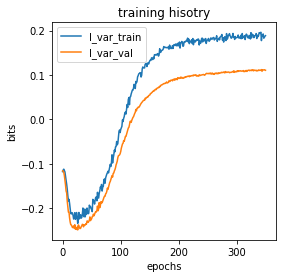

In [19]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')

In [20]:
phi = gpmap.x_to_phi(x_test)

In [21]:
theta = np.squeeze(gpmap.weights[1].numpy())
theta_df = pd.DataFrame(theta,columns=model.alphabet)

In [31]:
theta_df.loc[10:20].shape

(10, 20)

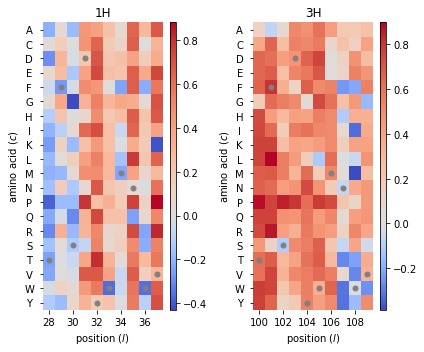

In [46]:
fig, axs = plt.subplots(1,2, figsize=(6,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs[0],
                                values=theta_df.loc[0:9].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H')

heatmap_ax, cb = mavenn.heatmap(ax=axs[1],
                                values=theta_df.loc[10:20].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(100,110,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'3H')

fig.tight_layout()
fig.savefig('pngs/DiscreteAgnostic_MP/GP_map.png',dpi=200,bbox_inches='tight')

In [23]:
#np.save('titeseq_gpmap_discrete_agnostic',logo.df.values.ravel())

In [24]:
# sortseq_gpmap = np.load('sortseq_gpmap_discrete_agnostic.npy')
# titeseq_gpmap = -np.load('titeseq_gpmap_discrete_agnostic.npy')

In [25]:
# plt.figure(figsize=(5,5))
# # Compute R^2 between yhat_test and y_test
# Rsq = np.corrcoef(sortseq_gpmap,titeseq_gpmap)[0, 1]**2

# # Style plot
# xlim = [-1.5, 1.5]

# plt.scatter(sortseq_gpmap,titeseq_gpmap,s=4,color='blue',alpha=0.2)
# plt.xlabel('Sortseq G-P map parameters')
# plt.ylabel('Titeseq G-P map parameters')
# plt.title(f'$R^2$={Rsq:.3}');
# plt.plot(xlim, xlim, '--', color='k', label='diagonal')
# plt.xlim(xlim)
# plt.ylim(xlim)
# plt.show()

/var/folders/kx/rdhxdz2129n1dd59rnympr580000gp/T/ipykernel_61929/2225179985.py:41: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = plt.colorbar(im)


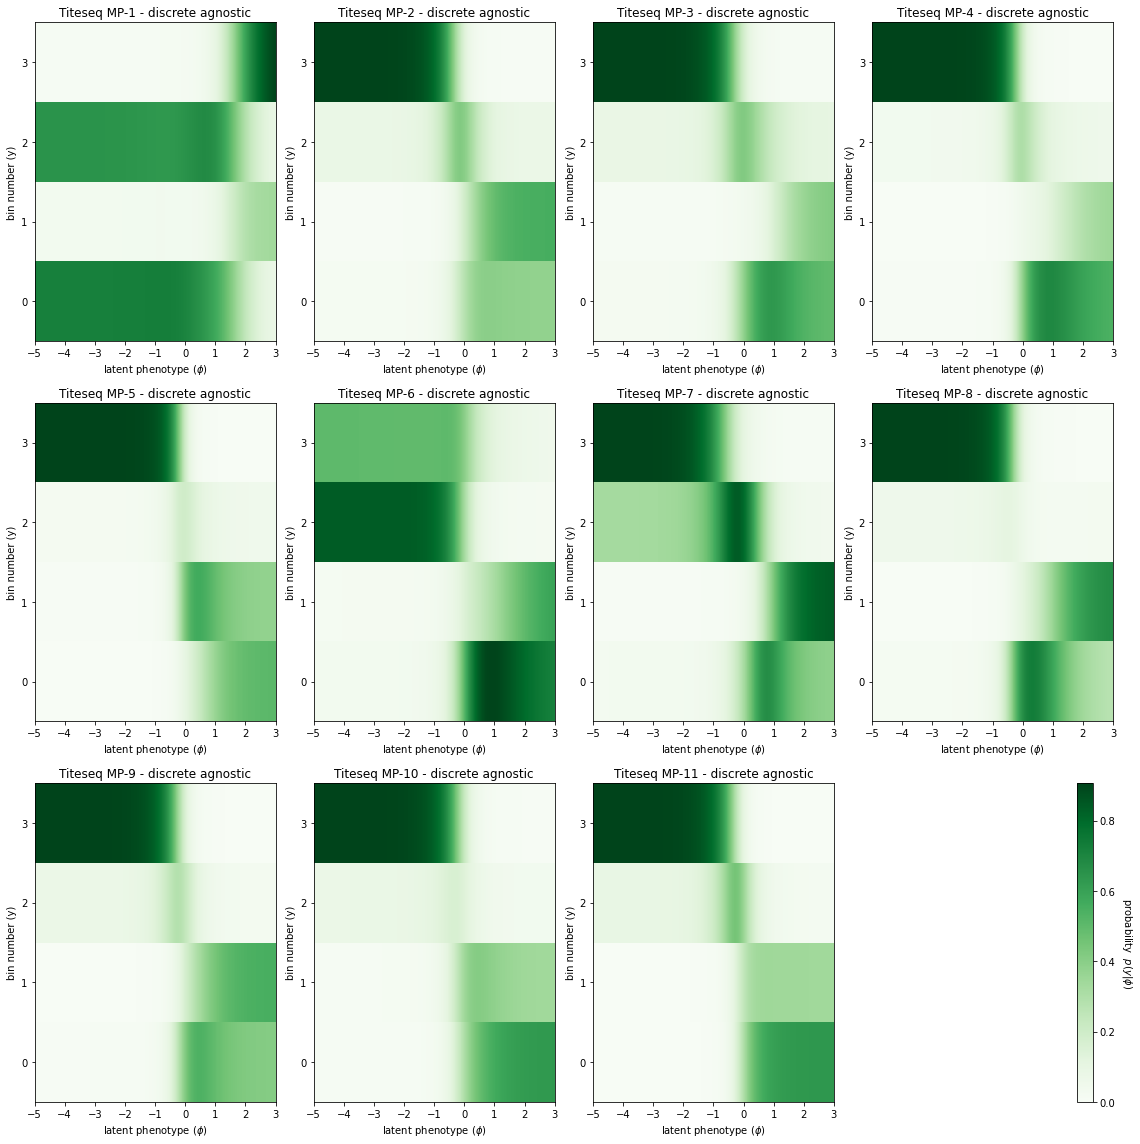

In [26]:
# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_list[0].Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values



# Create figure with two panels
fig, axs = plt.subplots(3,4,figsize=[16,16])

mp_counter = 0
for i in range(3):
    for j in range(4):
        
        if mp_counter==11:
            axs[i,j].axis('off')
            break
        measurement_process = mp_list[mp_counter].p_of_y_given_phi(y_all, phi_grid)
        # Right panel: draw measurement process as heatmap
        ax = axs[i,j]

        im = ax.imshow(measurement_process,
                       cmap='Greens',
                       extent=phi_lim+y_lim,
                       vmin=0,
                       origin='lower',
                       interpolation='nearest',
                       aspect="auto")
        ax.set_yticks(y_all)
        ax.set_ylabel('bin number (y)')
        ax.set_xlabel('latent phenotype ($\phi$)')
        ax.set_title(f'Titeseq MP-{mp_counter+1} - discrete agnostic')
        mp_counter+=1
        
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()

fig.savefig('pngs/DiscreteAgnostic_MP/MPs.png',dpi=200,bbox_inches='tight')
